In [2]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


# Noise Modeling

1. White Noise modelling - small subtle values away from the mean

$$ f(x) = s(x) + N(\mu, \sigma ^2) $$

Since this model assumes additive, can remove by first subtracting the mean. Then to remove the variance, can use a kalman filter or some smoothing function such as moving average.

$$ g(x) = f(x) - \mu = s(x) + N(\mu, \sigma ^2) $$

2. Glitch Noise Modelling - short peaks that are very large in value add noise

$$ f(x) = s(x) + $$

In [97]:
def subtract_from_prev_val(df, col, init_val=0):
    return (df[col] - df.shift()[col])


def metric(x, true):
    return np.sum(np.power(x - true,2)) / (len(x) - 1)


def differentiate(fxdx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = fxdx_col.tolist()
    f_prime = [init_val]*len(fxdx_col)
    fx_n_1 = init_val
    for i in xrange(len(fxdx_col)):
        y_val = fxdx_l[i] - fx_n_1
        f_prime[i] = y_val
        fx_n_1 = fxdx_l[i]
        
    return np.array(f_prime)

# Integration Techniques

In [23]:
def integrate_rect_col(fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = fxdx_col.tolist()
    dx_l = dx_col.tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * fxdx_l[i]
        y[i] = y_val
        prev_val = y_val
        
    return np.array(y)


$$ \omega = {d\theta}/{dt} $$
$$ \theta = \int \omega dt $$

$$ \theta[n] = \theta[n-1] + \Delta t \times \omega[n]$$

In [26]:

def integrate_trapezoid_col(fxdx_col, dx_col, init_val):
    """
    Numeric integration from a panda data frame.
    Uses simply box method
    """
    fxdx_l = fxdx_col.tolist()
    dx_l = dx_col.tolist()
    prev_val = init_val
    y = [init_val]*len(df)
    prev_fx = 0
    for i in xrange(len(df)):
        y_val = prev_val + float(dx_l[i]) * (fxdx_l[i]  + prev_fx) / 2
        y[i] = y_val
        prev_val = y_val
        prev_fx = fxdx_l[i]
        
    return np.array(y)


$$ \omega = {d\theta}/{dt} $$
$$ \theta = \int \omega dt $$

$$ \theta[n] = \theta[n-1] + \Delta t \times (\omega[n] + \omega[n-1]) / 2$$

In [10]:
#### COEFFICIENTS #####

noise_mean = df_noise['gz'].mean()
noise_var = np.var(df_noise['gz'])

In [102]:
df_noise = pd.read_csv('stagnant_long_test_00.csv')
df_noise['timediff'] = subtract_from_prev_val(df_noise, 'timestamp').fillna(0)

# df_noise= df_noise[df_noise['gz'] > df_noise['gz'].mean() - 3*df_noise['gz'].std()]
df = df_noise
df_signal = pd.read_csv('left_test_03.csv')
df_noise['gza'] = differentiate(df_noise['gz'], noise_mean)
df_signal['gza'] = differentiate(df_signal['gz'], noise_mean)

In [99]:
print len(a)
print len(df_noise)
print len(df_signal)

2442
2442
92


In [60]:
y = df['gz'] - noise_mean
theta =integrate_trapezoid_col(df['timediff'] / 1000, y/16.4, 0)
print 'trapezoid:', metric(theta, 0)
theta_rect =integrate_rect_col(df['timediff'] / 1000, y/16.4, 0)
print 'rect:', metric(theta_rect, 0)

trapezoid: 0.0274520335802
rect: 0.0277539806524


In [88]:
print df_noise['gza'].max()
print a.max()

2.19287469287
2.19287469287


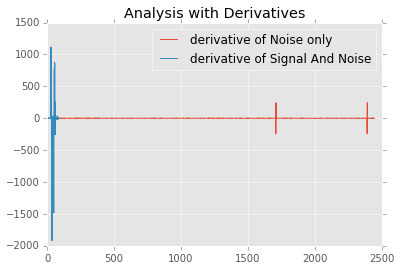

In [106]:
plt.plot(df_noise['gza'], label='derivative of Noise only')
plt.plot(df_signal['gza'], label='derivative of Signal And Noise')
plt.legend()
plt.title('Analysis with Derivatives')
# plt.plot(a)

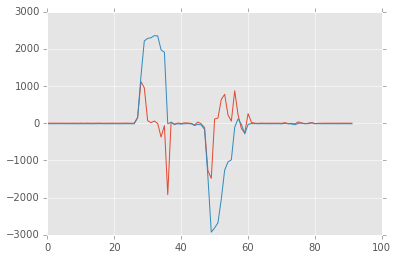

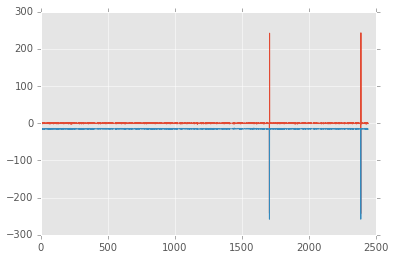

In [109]:
plt.plot(df_signal['gza'])
plt.plot(df_signal['gz'])
plt.figure()
plt.plot(df_noise['gza'])
plt.plot(df_noise['gz'])

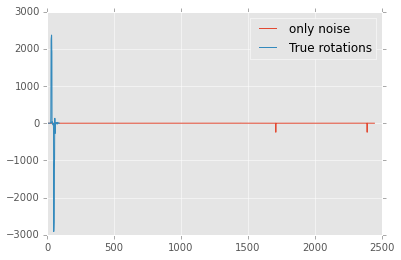

In [52]:
plt.plot(df_noise['gz'] - noise_mean, label='only noise')
plt.plot(df_signal['gz'] - noise_mean, label = 'True rotations')
plt.legend()

0.93200823602


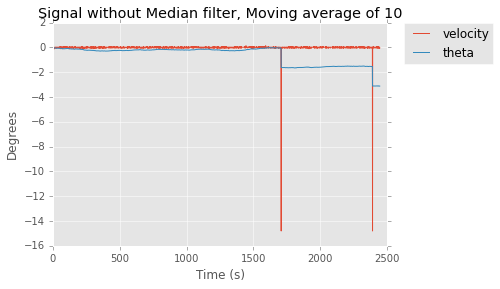

In [53]:
y = df['gz'] - noise_mean
theta = integrate_trapezoid_col(df['timediff'] / 1000, y/16.4, 0)
plt.plot(y/16.4, label='velocity')
plt.plot(theta, label='theta')
plt.title('Signal without Median filter, Moving average of 10')
plt.xlabel('Time (s)')
plt.ylabel('Degrees')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
print metric(theta,0)
